<a href="https://colab.research.google.com/github/vishalsahuu/Book-Recommendation-System/blob/main/Book_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Project Title: Book Recommendation System**

## **Project Description**

### **Problem Statement**
---
During the last few decades, with the rise of Youtube, Amazon, Netflix, and many other such web services, recommender systems have taken more and more place in our lives. From e-commerce (suggest to buyers articles that could interest them) to online advertisement (suggest to users the right contents, matching their preferences), recommender systems are today unavoidable in our daily online journeys.

In a very general way, recommender systems are algorithms aimed at suggesting relevant items to users (items being movies to watch, text to read, products to buy, or anything else depending on industries).

Recommender systems are really critical in some industries as they can generate a huge amount of income when they are efficient or also be a way to stand out significantly from competitors. The main objective is to create a book recommendation system for users.

### **Dataset Description**
---
The Book-Crossing dataset comprises 3 files.

* **Users:** Contains the users. Note that user IDs (User-ID) have been anonymized and map to integers. Demographic data is provided (Location, Age) if available. Otherwise, these fields contain NULL values.

* **Books:** Books are identified by their respective ISBN. Invalid ISBNs have already been removed from the dataset. Moreover, some content-based information is given (Book-Title, Book-Author, Year-Of-Publication, Publisher), obtained from Amazon Web Services. Note that in the case of several authors, only the first is provided. URLs linking to cover images are also given, appearing in three different flavors (Image-URL-S, Image-URL-M, Image-URL-L), i.e., small, medium, large. These URLs point to the Amazon website.

* **Ratings:** Contains the book rating information. Ratings (Book-Rating) are either explicit, expressed on a scale from 1-10 (higher values denoting higher appreciation), or implicit, expressed by 0.


In [1]:
# Importing important libraries and modules

# For data reading and manipulation
import pandas as pd
import numpy as np

# For data visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(8,5),'figure.dpi':100})
import seaborn as sns
import random

# This is to supress the warning messages (if any) generated in our code
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading the csv datasets
df_books=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Books.csv')
df_ratings=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Ratings.csv')
df_users=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PROJECTS/Unsupervised ML/Users.csv')

In [3]:
df_books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [4]:
df_books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271359 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [5]:
df_books.describe()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
count,271360,271360,271359,271360,271358,271360,271360,271357
unique,271360,242135,102023,202,16807,271044,271044,271041
top,0195153448,Selected Poems,Agatha Christie,2002,Harlequin,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/185326119X.0...,http://images.amazon.com/images/P/225307649X.0...
freq,1,27,632,13903,7535,2,2,2


In [6]:
df_ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [7]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [8]:
df_ratings.describe()

,User-ID,Book-Rating
count,1.149780e+06,1.149780e+06
mean,1.403864e+05,2.866950e+00
std,8.056228e+04,3.854184e+00
min,2.000000e+00,0.000000e+00
25%,7.034500e+04,0.000000e+00
50%,1.410100e+05,0.000000e+00
75%,2.110280e+05,7.000000e+00
max,2.788540e+05,1.000000e+01


In [9]:
df_users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [10]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


Age column has alot of missing values.

In [11]:
df_users.describe()

,User-ID,Age
count,278858.00000,168096.000000
mean,139429.50000,34.751434
std,80499.51502,14.428097
min,1.00000,0.000000
25%,69715.25000,24.000000
50%,139429.50000,32.000000
75%,209143.75000,44.000000
max,278858.00000,244.000000


There is the high imbalance in age column having max age of 244 and minimum age of 0 which could be due to some error.

In [12]:
# Size of datasets
print(f'''\t  Size of books data is {df_books.shape}
          Size of ratings data is {df_ratings.shape}
          Size of users data is {df_users.shape}''')

	  Size of books data is (271360, 8)
          Size of ratings data is (1149780, 3)
          Size of users data is (278858, 3)


## **Pre-processing and Cleaning**

In [13]:
# Dropping last three columns containing image URLs which will not be required for the analysis
df_books.drop(['Image-URL-S', 'Image-URL-M', 'Image-URL-L'],axis=1,inplace=True)

# Making column names handy to use
# Replacing '-' with '_' and column name in lower case
df_books.columns= df_books.columns.str.strip().str.lower().str.replace('-', '_')
df_users.columns= df_users.columns.str.strip().str.lower().str.replace('-', '_')
df_ratings.columns= df_ratings.columns.str.strip().str.lower().str.replace('-', '_')

# To display the entire content of a column
pd.set_option('display.max_colwidth', -1)

In [14]:
# A function to get the missing values count and it's percentage
def missing_values(df):
  print(f'Count of missing values is \n{df.isnull().sum()}')
  print('-'*30)
  print(f'Percentage of missng values is \n{df.isnull().mean()*100}')

In [15]:
# getting unique value from 'year_of_publication' feature
df_books['year_of_publication'].unique()

array([2002, 2001, 1991, 1999, 2000, 1993, 1996, 1988, 2004, 1998, 1994,
       2003, 1997, 1983, 1979, 1995, 1982, 1985, 1992, 1986, 1978, 1980,
       1952, 1987, 1990, 1981, 1989, 1984, 0, 1968, 1961, 1958, 1974,
       1976, 1971, 1977, 1975, 1965, 1941, 1970, 1962, 1973, 1972, 1960,
       1966, 1920, 1956, 1959, 1953, 1951, 1942, 1963, 1964, 1969, 1954,
       1950, 1967, 2005, 1957, 1940, 1937, 1955, 1946, 1936, 1930, 2011,
       1925, 1948, 1943, 1947, 1945, 1923, 2020, 1939, 1926, 1938, 2030,
       1911, 1904, 1949, 1932, 1928, 1929, 1927, 1931, 1914, 2050, 1934,
       1910, 1933, 1902, 1924, 1921, 1900, 2038, 2026, 1944, 1917, 1901,
       2010, 1908, 1906, 1935, 1806, 2021, '2000', '1995', '1999', '2004',
       '2003', '1990', '1994', '1986', '1989', '2002', '1981', '1993',
       '1983', '1982', '1976', '1991', '1977', '1998', '1992', '1996',
       '0', '1997', '2001', '1974', '1968', '1987', '1984', '1988',
       '1963', '1956', '1970', '1985', '1978', '1973', '1980'

In [16]:
# Missing values in books data
missing_values(df_books)

Count of missing values is 
isbn                   0
book_title             0
book_author            1
year_of_publication    0
publisher              2
dtype: int64
------------------------------
Percentage of missng values is 
isbn                   0.000000
book_title             0.000000
book_author            0.000369
year_of_publication    0.000000
publisher              0.000737
dtype: float64


In [17]:
df_books.loc[(df_books['publisher'].isnull()),:]

,isbn,book_title,book_author,year_of_publication,publisher
128890,193169656X,Tyrant Moon,Elaine Corvidae,2002,NaN
129037,1931696993,Finders Keepers,Linnea Sinclair,2001,NaN


In [18]:
df_books['publisher'].fillna('Unknown',inplace=True)

In [19]:
df_books.loc[(df_books['book_author'].isnull()),:]

,isbn,book_title,book_author,year_of_publication,publisher
187689,9627982032,The Credit Suisse Guide to Managing Your Personal Wealth,NaN,1995,Edinburgh Financial Publishing


In [20]:
df_books['book_author'].fillna('Unknown',inplace=True)

In [21]:
# Extracting the mismatched values in features 'year_of_publication', 'publisher', 'book_author', and 'book_title'
df_books[(df_books['year_of_publication'] == 'DK Publishing Inc') | (df_books['year_of_publication'] == 'Gallimard')]

,isbn,book_title,book_author,year_of_publication,publisher
209538,078946697X,"DK Readers: Creating the X-Men, How It All Began (Level 4: Proficient Readers)\"";Michael Teitelbaum""",2000,DK Publishing Inc,http://images.amazon.com/images/P/078946697X.01.THUMBZZZ.jpg
220731,2070426769,"Peuple du ciel, suivi de 'Les Bergers\"";Jean-Marie Gustave Le ClÃ?Â©zio""",2003,Gallimard,http://images.amazon.com/images/P/2070426769.01.THUMBZZZ.jpg
221678,0789466953,"DK Readers: Creating the X-Men, How Comic Books Come to Life (Level 4: Proficient Readers)\"";James Buckley""",2000,DK Publishing Inc,http://images.amazon.com/images/P/0789466953.01.THUMBZZZ.jpg


In [22]:
# Function to replace values of different columns
def replace_values(index,column1,column2,column3,column4):
  temp = df_books.loc[index,column1]
  df_books.loc[index,column1] = df_books.loc[index,column2]
  df_books.loc[index,column2] = df_books.loc[index,column3].split(';')[1]
  df_books.loc[index,column4] = temp

In [23]:
# Fixing the mismatched values of features 'year_of_publication', 'publisher', 'book_author', and 'book_title'
replace_values(209538,'year_of_publication','book_author','book_title','publisher')
replace_values(221678,'year_of_publication','book_author','book_title','publisher')
replace_values(220731,'year_of_publication','book_author','book_title','publisher')

In [24]:
df_books['year_of_publication'] = df_books['year_of_publication'].astype(int)

In [25]:
df_books['year_of_publication'].sort_values().unique()

array([   0, 1376, 1378, 1806, 1897, 1900, 1901, 1902, 1904, 1906, 1908,
       1909, 1910, 1911, 1914, 1917, 1919, 1920, 1921, 1922, 1923, 1924,
       1925, 1926, 1927, 1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935,
       1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944, 1945, 1946,
       1947, 1948, 1949, 1950, 1951, 1952, 1953, 1954, 1955, 1956, 1957,
       1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968,
       1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979,
       1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2008, 2010, 2011, 2012, 2020, 2021,
       2024, 2026, 2030, 2037, 2038, 2050])

In [26]:
missing_values(df_users)

Count of missing values is 
user_id     0     
location    0     
age         110762
dtype: int64
------------------------------
Percentage of missng values is 
user_id     0.000000 
location    0.000000 
age         39.719857
dtype: float64


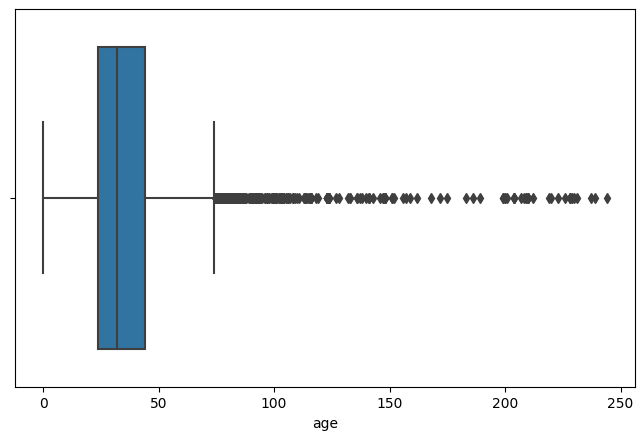

In [27]:
sns.boxplot(df_users['age'])

In [28]:
# Outlier data became NaN
df_users.loc[(df_users.age > 90) | (df_users.age < 10), 'age'] = np.nan

In [29]:
df_users['age'].fillna(df_users.groupby('location')['age'].transform('median'),inplace=True)

In [30]:
missing_values(df_users['age'])

Count of missing values is 
18626
------------------------------
Percentage of missng values is 
6.6793852068077655


In [31]:
df_users['age'].fillna(df_users.age.mean(),inplace=True)

In [32]:
missing_values(df_users['age'])

Count of missing values is 
0
------------------------------
Percentage of missng values is 
0.0


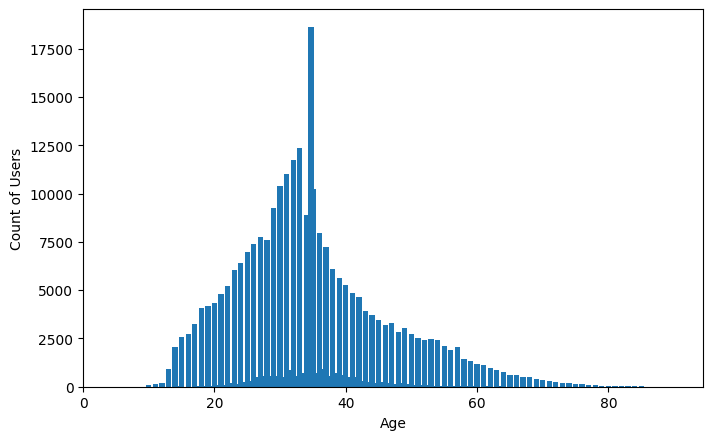

In [33]:
u = df_users.age.value_counts().sort_index()
plt.bar(u.index, u.values)
plt.xlabel('Age')
plt.ylabel('Count of Users')
plt.xlim(xmin = 0)
plt.show()

Text(0.5, 1.0, 'Top 10 authors according to number of books published')

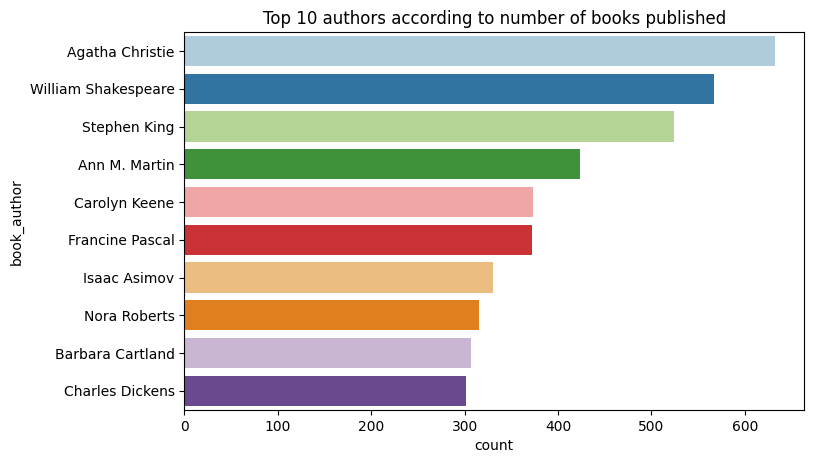

In [34]:
sns.countplot(y="book_author",palette = 'Paired', data=df_books,order=df_books['book_author'].value_counts().index[:10])
plt.title("Top 10 authors according to number of books published")

Text(0.5, 1.0, 'Top 10 Publishers')

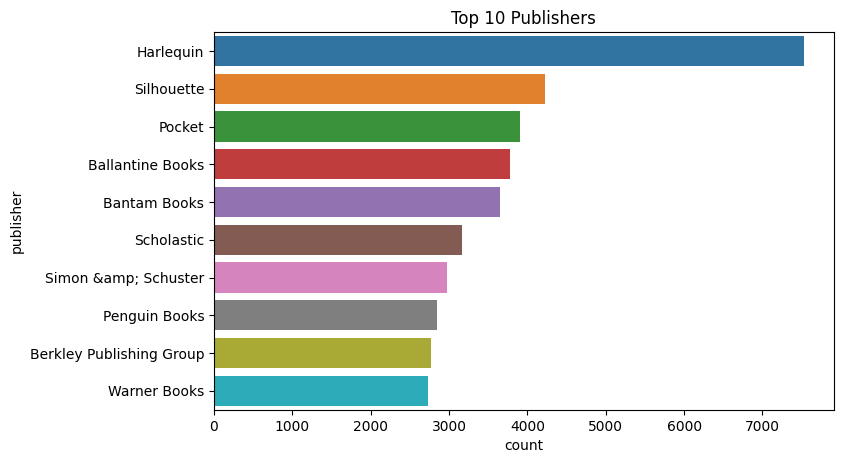

In [35]:
sns.countplot(y='publisher',data=df_books,order=pd.value_counts(df_books['publisher']).iloc[:10].index)
plt.title('Top 10 Publishers')

In [36]:
df_books[df_books['year_of_publication']!=0]['year_of_publication'].value_counts()

2002    17627
1999    17431
2001    17359
2000    17234
1998    15766
        ...  
1910    1    
1934    1    
1914    1    
1904    1    
2037    1    
Name: year_of_publication, Length: 115, dtype: int64

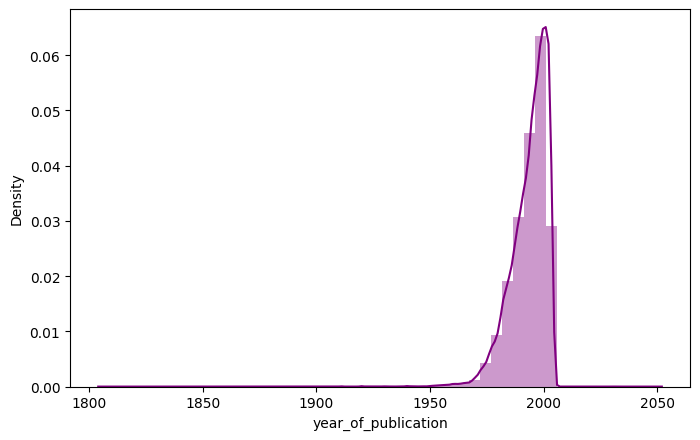

In [37]:
sns.distplot(df_books[df_books['year_of_publication']>1800]['year_of_publication'],color='purple',bins=50)

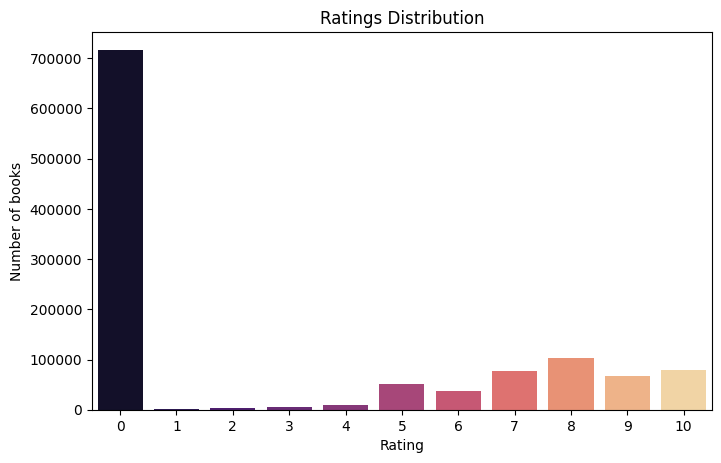

In [38]:
sns.barplot(x = df_ratings['book_rating'].value_counts().index,y = df_ratings['book_rating'].value_counts().values,
            palette = 'magma').set(title="Ratings Distribution",xlabel = "Rating",ylabel = 'Number of books')
plt.show()

Text(0.5, 1.0, 'Explicit Ratings')

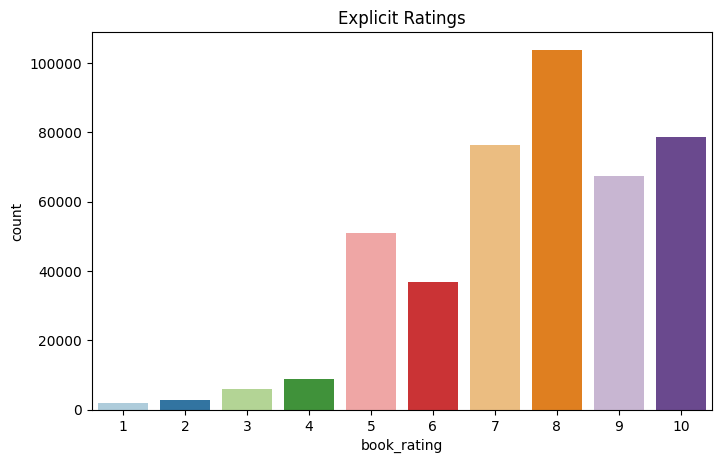

In [39]:
# Explicit Ratings
explicit_ratings_df = df_ratings[df_ratings['book_rating'] != 0]
sns.countplot(x="book_rating",palette = 'Paired',data=explicit_ratings_df)
plt.title("Explicit Ratings")

In [40]:
# Merging book_data dataset and ratings_explicit
final_df= pd.merge(df_books, explicit_ratings_df, on='isbn')
final_df.head()

,isbn,book_title,book_author,year_of_publication,publisher,user_id,book_rating
0,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8,5
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,11676,8
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,67544,8
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,116866,9
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,123629,9


In [41]:
missing_values(final_df)

Count of missing values is 
isbn                   0
book_title             0
book_author            0
year_of_publication    0
publisher              0
user_id                0
book_rating            0
dtype: int64
------------------------------
Percentage of missng values is 
isbn                   0.0
book_title             0.0
book_author            0.0
year_of_publication    0.0
publisher              0.0
user_id                0.0
book_rating            0.0
dtype: float64
